# Well

Some preliminaries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import welly
welly.__version__

'0.4.10.dev35+g5a439b6.d20220207'

## Make an 'empty' well

In [2]:
w = welly.Well()
w.header  # is empty

,original_mnemonic,mnemonic,unit,value,descr,section


We can set the **UWI** and **name** of a well directly on the well object, but these are the only attributes of the well we can set in this way.

In [3]:
w.uwi = 'foo'
w.uwi

/home/matt/miniconda3/envs/welly/lib/python3.9/site-packages/welly/well.py:1150: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.header = self.header.append(new_row, ignore_index=True)


'foo'

In [4]:
w.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,UWI,UWI,None,foo,None,header


## Load a well from LAS

Use the `from_las()` method to load a well by passing a filename as a `str`. 

This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [5]:
from welly import Well

In [6]:
w = Well.from_las('data/P-129_out.LAS', remap={'KB': 'EKB', 'UWI': 'WELL'})

Only engine='normal' can read wrapped files


The well's `header` contains the basic well information from the **WELL** part of the file.

In [7]:
w.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,VERS,VERS,,2.0,,Version
1,WRAP,WRAP,,YES,,Version
2,STRT,STRT,M,1.0668,START DEPTH,Well
3,STOP,STOP,M,1939.1376,STOP DEPTH,Well
4,STEP,STEP,M,0.1524,STEP,Well
...,...,...,...,...,...,...
137,TLI,TLI,M,280.0,Top Log Interval,Parameter
138,UWID,UWID,,,Unique Well Identification Number,Parameter
139,WN,WN,,Kennetcook #2,Well Name,Parameter
140,EPD,EPD,M,90.300003,Elevation of Permanent Datum above Mean Sea Level,Parameter


The well's `location` contains the location info from **PARAMS**:

In [8]:
w.location

Location({'position': None, 'crs': CRS({}), 'location': 'Lat = 45* 12\' 34.237" N', 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '', 'longitude': '', 'datum': '', 'section': '45.20 Deg N', 'range': 'PD 176', 'township': '63.75 Deg W', 'ekb': 94.8, 'egl': 90.3, 'kb': 94.8, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'td': None, 'deviation': None})

In [9]:
w.location.kb

94.8

## Write a LAS file

In [10]:
w.to_las('data/x.las', null_value=-111.111)

In [11]:
!ls -l data/x.las

-rw-rw-r-- 1 matt matt 3517435 Feb  7 16:43 data/x.las


In [12]:
!head -100 data/x.las

~Version ---------------------------------------------------
VERS.   2.0 : CWLS log ASCII Standard -VERSION 2.0
WRAP.    NO : One line per depth step
DLM . SPACE : Column Data Section Delimiter
~Well ------------------------------------------------------
STRT  .m                    1.06680 : START DEPTH
STOP  .m                 1939.13760 : STOP DEPTH
STEP  .m                    0.15240 : STEP
NULL  .                    -111.111 : NULL VALUE
COMP  . Elmworth Energy Corporation : COMPANY
WELL  .               Kennetcook #2 : WELL
FLD   .               Windsor Block : FIELD
LOC   .     Lat = 45* 12' 34.237" N : LOCATION
PROV  .                 Nova Scotia : PROVINCE
CNTY  .                             : COUNTY
STAT  .                             : STATE
CTRY  .                          CA : COUNTRY
SRVC  .                             : SERVICE COMPANY
DATE  .  2022-02-07 16:43:06.986846 : DATE
UWI   .               Kennetcook #2 : UNIQUE WELL ID
API   .                             : API 

## Quick plot

`welly` produces `matplotlib` plots easily... but they aren't all that pretty. You can pass in an Axes object as `ax`, and you can embellish the plots by adding more `matplotlib` commands.

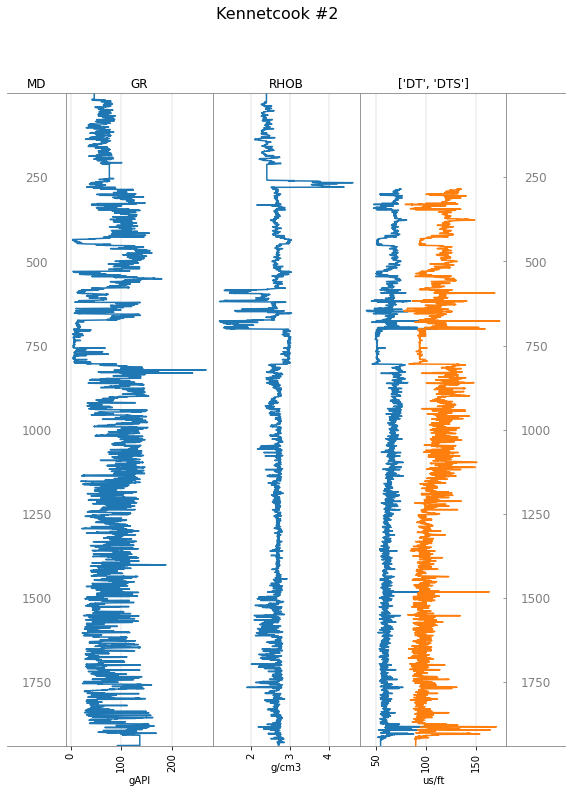

In [13]:
tracks = ['MD', 'GR', 'RHOB', ['DT', 'DTS'], 'MD']
w.plot(tracks=tracks)

## Aliases and curve quality

We can define aliases for curves, and check the quality of curves with a dictionary of tests:

In [14]:
alias = {
    "Gamma": ["GR", "GAM", "GRC", "SGR", "NGT"],
    "Density": ["RHOZ", "RHOB", "DEN", "RHOZ"],
    "Sonic": ["DT", "AC", "DTP", "DT4P"],
    "Caliper": ["CAL", "CALI", "CALS", "C1"],
    'Porosity SS': ['NPSS', 'DPSS'],
}

In [15]:
import welly.quality as q

tests = {
    'Each': [
        q.no_flat,
        q.no_monotonic,
        q.no_gaps,
    ],
    'Gamma': [
        q.all_positive,
        q.all_below(450),
        q.check_units(['API', 'GAPI']),
    ],
    'DT': [
        q.all_positive,
    ],
    'Sonic': [
        q.all_between(1, 10000),  # 1333 to 5000 m/s
        q.no_spikes(10),          # 10 spikes allowed
    ],
}

In [16]:
w = Well.from_las('data/P-129_out.LAS')
r = w.qc_data(tests, alias=alias)

Only engine='normal' can read wrapped files


This returns a dictionary of curves in which the values are dictionaries of **test name: test result** pairs.

In [17]:
r

{'CALI': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'HCAL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'PEF': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DT': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': True,
  'all_positive': True,
  'all_between': True,
  'no_spikes': False},
 'DTS': {'no_flat': True, 'no_monotonic': True, 'no_gaps': True},
 'DPHI_SAN': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DPHI_LIM': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DPHI_DOL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_SAN': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_LIM': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_DOL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA5': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA3': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA4': {'no_

There's also an HTML table for rendering in Notebooks:

In [18]:
from IPython.display import HTML
html = w.qc_table_html(tests, alias=alias)
HTML(html)

Curve,Passed,Score,all_between,no_monotonic,all_positive,all_below,no_spikes,no_flat,check_units,no_gaps
CALI,1 / 3,0.333,,False,,,,False,,True
HCAL,1 / 3,0.333,,False,,,,False,,True
PEF,1 / 3,0.333,,False,,,,False,,True
DT,5 / 6,0.833,True,True,True,,False,True,,True
DTS,3 / 3,1.000,,True,,,,True,,True
DPHI_SAN,1 / 3,0.333,,False,,,,False,,True
DPHI_LIM,1 / 3,0.333,,False,,,,False,,True
DPHI_DOL,1 / 3,0.333,,False,,,,False,,True
NPHI_SAN,1 / 3,0.333,,False,,,,False,,True
NPHI_LIM,1 / 3,0.333,,False,,,,False,,True


## Add a striplog

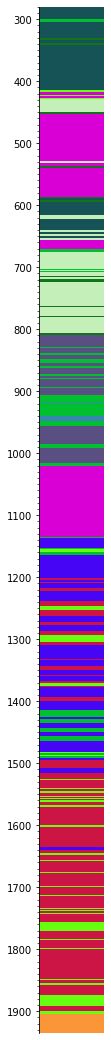

In [19]:
from striplog import Legend, Striplog
legend = Legend.builtin('NSDOE')
strip = Striplog.from_image('data/P-129_280_1935.png', 280, 1935, legend=legend)
strip.plot()

In [20]:
w.data['strip'] = strip

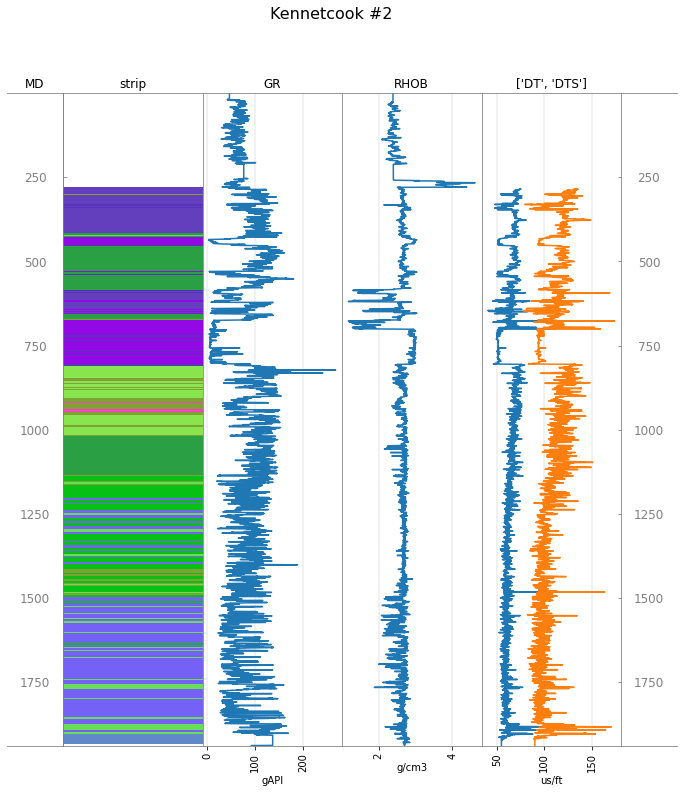

In [21]:
tracks = ['MD', 'strip', 'GR', 'RHOB', ['DT', 'DTS'], 'MD']
w.plot(tracks=tracks)

## Header

Maybe should be called 'meta' as it's not really a header... 

In [22]:
w.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,VERS,VERS,,2.0,,Version
1,WRAP,WRAP,,YES,,Version
2,STRT,STRT,M,1.0668,START DEPTH,Well
3,STOP,STOP,M,1939.1376,STOP DEPTH,Well
4,STEP,STEP,M,0.1524,STEP,Well
...,...,...,...,...,...,...
137,TLI,TLI,M,280.0,Top Log Interval,Parameter
138,UWID,UWID,,,Unique Well Identification Number,Parameter
139,WN,WN,,Kennetcook #2,Well Name,Parameter
140,EPD,EPD,M,90.300003,Elevation of Permanent Datum above Mean Sea Level,Parameter


In [23]:
w.uwi  # Fails because not present in this file. See one way to add it in a minute.

"Long = 63* 45'24.460  W"

## Location and CRS

In [24]:
w.location

Location({'position': None, 'crs': CRS({}), 'location': 'Lat = 45* 12\' 34.237" N', 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '', 'longitude': '', 'datum': '', 'section': '45.20 Deg N', 'range': 'PD 176', 'township': '63.75 Deg W', 'ekb': 94.8, 'egl': 90.3, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'td': None, 'deviation': None})

In [25]:
from welly import CRS
w.location.crs = CRS.from_epsg(2038)

In [26]:
w.location.crs

CRS({'init': 'epsg:2038', 'no_defs': True})

Right now there's no position log — we need to load a deviation survey.

In [27]:
w.location.position

## Add deviation data to a well

In [28]:
import numpy as np
from welly import Well

p = Well.from_las('data/P-130_out.LAS')

In [29]:
dev = np.loadtxt('data/P-130_deviation_survey.csv', delimiter=',', skiprows=1)

The columns are MD, inclination, azimuth, and TVD.

In [30]:
dev[:5]

array([[ 18. ,   0.3,   0. ,  18. ],
       [ 38. ,   0.5,   0. ,  38. ],
       [ 57. ,   1.5,   0. ,  57. ],
       [ 84. ,   1.8,   0. ,  84. ],
       [104. ,   0.5,   0. , 104. ]])

`add_deviation` assumes those are the columns, and computes a position log.

In [31]:
p.location.add_deviation(dev[:, :3], td=2618.3)

The columns in the position log are _x_ offset, _y_ offset, and TVD.

In [32]:
p.location.position[:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.71237821e-02, 1.79999178e+01],
       [0.00000000e+00, 1.86748917e-01, 3.79994202e+01],
       [0.00000000e+00, 5.18340431e-01, 5.69962853e+01],
       [0.00000000e+00, 1.29577626e+00, 8.39850594e+01]])

In [33]:
p.location.trajectory()

array([[ 6.45933639e-01,  3.47023772e-01, -1.65395432e-02],
       [ 5.90396925e-01,  3.28218888e-01, -2.63643779e+00],
       [ 5.36457735e-01,  3.11968468e-01, -5.25632568e+00],
       ...,
       [-3.68094384e+00,  3.97484953e+01, -2.61112780e+03],
       [-3.68832058e+00,  3.96833189e+01, -2.61374906e+03],
       [-3.69619567e+00,  3.96172858e+01, -2.61637033e+03]])

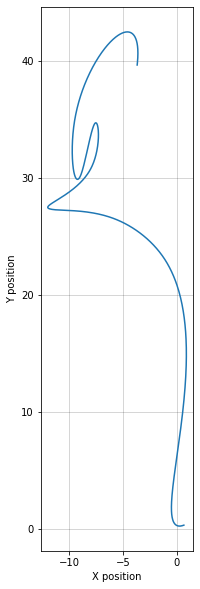

In [34]:
p.location.plot_plan()

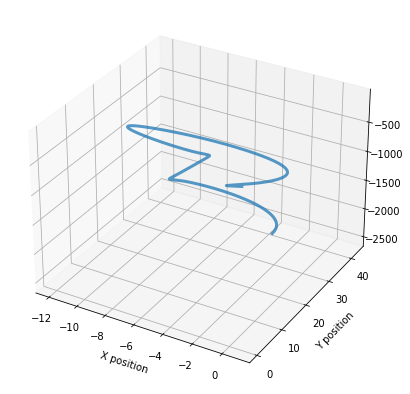

In [35]:
p.location.plot_3d()

## Export curves to data matrix

Make a NumPy array:

In [36]:
w.data_as_matrix()

array([[Curve(mnemonic=CALI, units=in, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=HCAL, units=in, start=1.0668, stop=1939.1376, step=0.1524, count=[2138]),
        Curve(mnemonic=PEF, units=, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=DT, units=us/ft, start=1.0668, stop=1939.1376, step=0.1524, count=[10849]),
        Curve(mnemonic=DTS, units=us/ft, start=1.0668, stop=1939.1376, step=0.1524, count=[10849]),
        Curve(mnemonic=DPHI_SAN, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=DPHI_LIM, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=DPHI_DOL, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=NPHI_SAN, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, count=[12717]),
        Curve(mnemonic=NPHI_LIM, units=m3/m3, start=1.0668, stop=1939.1376, step=0.1524, co

## Export curves to pandas

Pandas is an optional dependency. You'll need it to make this work.

In [37]:
df = w.df()

In [38]:
df.head()

,CALI,HCAL,PEF,DT,DTS,DPHI_SAN,DPHI_LIM,DPHI_DOL,NPHI_SAN,NPHI_LIM,...,RLA1,RLA2,RXOZ,RXO_HRLT,RT_HRLT,RM_HRLT,DRHO,RHOB,GR,SP
DEPT,,,,,,,,,,,,,,,,,,,,,
1.0668,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125
1.2192,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125
1.3716,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125
1.5240,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125
1.6764,2.4438154697,4.3912849426,3.586400032,NaN,NaN,0.1574800014,0.1984400004,0.2590999901,0.4650999904,0.3364700079,...,0.0320999995,0.0279399995,0.0576100014,0.0255800001,0.0255800001,0.0550099984,0.1942329407,2.3901498318,46.69865036,120.125


<AxesSubplot:xlabel='DEPT'>

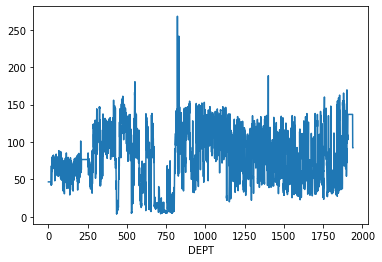

In [39]:
df.GR.plot()

This also gives us another path to getting a matrix:

In [40]:
w.df().values

array([[  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       ...,
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.        ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.9375    ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  74.25      ]])

You'll have to get depth separately:

In [41]:
w.df().index.values

array([1.0668000e+00, 1.2192000e+00, 1.3716000e+00, ..., 1.9388328e+03,
       1.9389852e+03, 1.9391376e+03])

To get the UWI of the well as well, e.g. if you want to combine multiple wells (maybe using `welly.Project.df()`):

In [42]:
df = w.df(uwi=True)

In [43]:
df.head()

CALI          HCAL          PEF  DT  \
UWI                     DEPT                                                  
Long = 63* 45'24.460  W 1.0668  2.4438154697  4.3912849426  3.586400032 NaN   
                        1.2192  2.4438154697  4.3912849426  3.586400032 NaN   
                        1.3716  2.4438154697  4.3912849426  3.586400032 NaN   
                        1.5240  2.4438154697  4.3912849426  3.586400032 NaN   
                        1.6764  2.4438154697  4.3912849426  3.586400032 NaN   

                                DTS      DPHI_SAN      DPHI_LIM      DPHI_DOL  \
UWI                     DEPT                                                    
Long = 63* 45'24.460  W 1.0668  NaN  0.1574800014  0.1984400004  0.2590999901   
                        1.2192  NaN  0.1574800014  0.1984400004  0.2590999901   
                        1.3716  NaN  0.1574800014  0.1984400004  0.2590999901   
                        1.5240  NaN  0.1574800014  0.1984400004  0.2590999901   
                        1.6764  NaN  0.1574800014  0.1984400004  0.2590999901   

                                    NPHI_SAN      NPHI_LIM  ...          RLA1  \
UWI                     DEPT                                ...                 
Long = 63* 45'24.460  W 1.0668  0.4650999904  0.3364700079  ...  0.0320999995   
                        1.2192  0.4650999904  0.3364700079  ...  0.0320999995   
                        1.3716  0.4650999904  0.3364700079  ...  0.0320999995   
                        1.5240  0.4650999904  0.3364700079  ...  0.0320999995   
                        1.6764  0.4650999904  0.3364700079  ...  0.0320999995   

                                        RLA2          RXOZ      RXO_HRLT  \
UWI                     DEPT                                               
Long = 63* 45'24.460  W 1.0668  0.0279399995  0.0576100014  0.0255800001   
                        1.2192  0.0279399995  0.0576100014  0.0255800001   
                        1.3716  0.0279399995  0.0576100014  0.0255800001   
                        1.5240  0.0279399995  0.0576100014  0.0255800001   
                        1.6764  0.0279399995  0.0576100014  0.0255800001   

                                     RT_HRLT       RM_HRLT          DRHO  \
UWI                     DEPT                                               
Long = 63* 45'24.460  W 1.0668  0.0255800001  0.0550099984  0.1942329407   
                        1.2192  0.0255800001  0.0550099984  0.1942329407   
                        1.3716  0.0255800001  0.0550099984  0.1942329407   
                        1.5240  0.0255800001  0.0550099984  0.1942329407   
                        1.6764  0.0255800001  0.0550099984  0.1942329407   

                                        RHOB           GR       SP  
UWI                     DEPT                                        
Long = 63* 45'24.460  W 1.0668  2.3901498318  46.69865036  120.125  
                        1.2192  2.3901498318  46.69865036  120.125  
                        1.3716  2.3901498318  46.69865036  120.125  
                        1.5240  2.3901498318  46.69865036  120.125  
                        1.6764  2.3901498318  46.69865036  120.125  

[5 rows x 24 columns]

### Pandas with an alias dictionary

In [44]:
alias

{'Gamma': ['GR', 'GAM', 'GRC', 'SGR', 'NGT'],
 'Density': ['RHOZ', 'RHOB', 'DEN', 'RHOZ'],
 'Sonic': ['DT', 'AC', 'DTP', 'DT4P'],
 'Caliper': ['CAL', 'CALI', 'CALS', 'C1'],
 'Porosity SS': ['NPSS', 'DPSS']}

In [48]:
keys = ['CALI', 'Gamma', 'Density', 'Sonic', 'RLA1']
w.df(keys=keys, alias=alias, rename_aliased=True).head()

,CALI,Gamma,Density,Sonic,RLA1
DEPT,,,,,
1.0668,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995
1.2192,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995
1.3716,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995
1.5240,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995
1.6764,2.4438154697,46.69865036,2.3901498318,NaN,0.0320999995


---

&copy; 2022 Agile Scientific, CC BY